## The BIG Wine Dataset
 ** explain what I'm gonna do in this notebook ** 
The dataset consists of the following columns:

Attribute Information
+ winery: Winery name
+ wine: Name of the wine
+ year: Year in which the grapes were harvested
+ rating: Average rating given to the wine by the users [from 1-5]
+ num_reviews: Number of users that reviewed the wine
+ country: Country of origin [Spain]
+ region: Region of the wine
+ price: Price in euros [€]
+ type: Wine variety
+ body: Body score, defined as the richness and weight of the wine in your mouth [from 1-5]
+ acidity: Acidity score, defined as wine's “pucker” or tartness; it's what makes a wine refreshing and your tongue + salivate and want another sip [from 1-5]

In [15]:
# seaborn to explore the data
import seaborn as sea

# as a relatively small dataset, the use of pandas is okay
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import feature_column as fc

from sklearn.model_selection import train_test_split

In [10]:
wine_ds = pd.read_csv("data/wines_SPA.csv")

In [38]:
# wine_ds.head()
wine_ds.describe()

,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


In [36]:
#The data is not very sparse. It sunks on different buckets. A bucketized feature could be useful for the "year" att
# sea.displot(wine_ds, x = "year")

# If the label we want to predict is "rating", a dropout layer (in training) could be usefull because of the huuge 
# difference between the quantity of the buckets:
# sea.displot(wine_ds, x = "rating")

# a lot of data is filled in certain buckets:
# sea.displot(wine_ds, x = "body")
# sea.displot(wine_ds, x = "acidity")

wine_ds.groupby("num_reviews").count() 

,winery,wine,year,rating,country,region,price,type,body,acidity
num_reviews,,,,,,,,,,
25,20,20,20,20,20,20,20,19,18,18
26,19,19,19,19,19,19,19,18,15,15
27,27,27,27,27,27,27,27,23,21,21
28,29,29,29,29,29,29,29,27,27,27
29,19,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...
9098,1,1,1,1,1,1,1,1,1,1
10273,1,1,1,1,1,1,1,1,1,1
12421,1,1,0,1,1,1,1,1,1,1


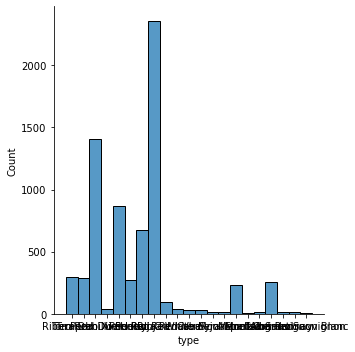

In [45]:
# Country column has only 1 value: poping
# wine_ds['country'].unique()
# wine_ds.pop('country')
wine_ds['type'].unique()

Now it's time to create the features. All the features will be feeded into feature_columns array. We'll be testing several models:
+ A baseline model
+ A model that uses all the features
+ A model that uses all the features but with a filtered dataset
+ A model that uses certain features with a filtered dataset

As seen in the plots, there's a lot of variance in the columns, some types of wine have almost none samples compared with others, the same goes for other features. Features with less data than usual can cause overfitting, because there's not enough variance on each type of value of each colum. Thereby, removing some of the categorical types and only leaving the ones that have a modest amount of samples, can help us avoid overfitting. 

For now, let's see how a model with all the columns (except contry, because it only has 1 value) performs:

In [53]:
# 10 att:
numeric_cols = ['year', 'rating', 'num_reviews', 'body', 'acidity']
# rating goes from 4.2 to 5
# num_reviews sparse

categorical_cols = ['winery', 'wine', 'region', 'type']

label = 'price'


In [57]:
feature_columns = []

for i in numeric_cols:
    feature_columns.append(fc.numeric_column(i))

type_vocab = wine_ds['type'].unique()
# for categorical cols:
# for winery (a lot of categories): 
winery_cat = fc.categorical_column_with_hash_bucket('winery', 10000)
feature_columns.append(fc.embedding_column(winery_cat, dimension= 10))

# for type (a bit less categories than winery): 
one_hot_type = fc.categorical_column_with_vocabulary_list('type', vocabulary_list= type_vocab)
feature_columns.append(fc.indicator_column(one_hot_type))

# for wine and region (a lot of categories):
wine_cat = fc.categorical_column_with_hash_bucket('wine', 10000)
feature_columns.append(fc.embedding_column(wine_cat, dimension=6)) 
region_cat = fc.categorical_column_with_hash_bucket('region', 1000)
feature_columns.append(fc.embedding_column(region_cat, dimension = 6))


In [66]:
feature_layer = layers.DenseFeatures(feature_columns, dtype = 'float64')

# now a function that converts a pandas dataframe to a tf dataset:
def pandas_to_tensor(dataframe, _shuffle_ = False, batch_size = 1):
    dataframe = dataframe.copy()
    labels = dataframe.pop(label)
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if _shuffle_:
        dataset.shuffle(len(dataset))
        dataset.batch(batch_size)

    return dataset

In [67]:
model_base = tf.keras.models.Sequential([
    feature_layer,
    layers.Dense(12, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1, activation='linear', name = 'price')
])

train_ds, test_ds = train_test_split(wine_ds, test_size= 0.2)
train_ds, val_ds = train_test_split(train_ds, test_size= 0.2)

train_ds = pandas_to_tensor(train_ds, True, 100)
val_ds = pandas_to_tensor(val_ds, batch_size= 10)

test_ds = pandas_to_tensor(test_ds, batch_size=10)

# ensure that the data is in np arrays

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).